In [1]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from scipy.stats import uniform
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from random import randint

# Import Data and Prepare the splitted data index

In [2]:
train_data = pd.read_csv("combined_train_with_features.csv")
valid_data = pd.read_csv("combined_valid_with_features.csv")

In [3]:
def MAE(y, y_pred):
    # y, y_pred are numpy.ndarray
    mae = sum(abs(y-y_pred)) / len(y)
    return mae

In [4]:
def split_data_index(data, K):
    
    index_arr = data.index.values
    shuffle_index_arr = copy.copy(index_arr)
    
#     random.seed(444)
    random.seed(222)
#     random.seed(1)
    shuffle_index_arr = shuffle_index_arr.reshape(-1,K)
    for arr in shuffle_index_arr:
        random.shuffle(arr)
    
    cv_outer = []
    for i in range(K):

        test_index = shuffle_index_arr[:,i]
        train_index = np.delete(shuffle_index_arr, i, axis=1).reshape(1,-1)[0]

        cv_outer.append([train_index, test_index])
    
    return cv_outer

In [5]:
cv_outer = split_data_index(train_data, 10)

# 1. Sigmoid

In [7]:
def sigmoid_cv(data, cv_outer):
    
    def sigmoid(x, L ,x0, k, a, b):
        y = L / (a + np.exp(-k*(x-x0)))+b
        return y
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    
    X = data['MolLogP'].values
    y = data['rtmed'].values
    for train_index, test_index in cv_outer:

        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        p0 = [max(y), np.median(X), 1, 1, min(y)] 
        popt, pcov = curve_fit(sigmoid, X_train, y_train, p0, maxfev = 5000)
        
        y_pred = sigmoid(X_test, *popt)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results

In [8]:
MAE_results, RMSE_results, MedAE_results, r2_results = sigmoid_cv(train_data, cv_outer)

In [9]:
def learning_curve_sigmoid(train_data, sample_seed):
    
    train_index_arr = train_data.index.values.reshape(10,-1)
    MAE_curve_list = []
    RMSE_curve_list = []
    MedAE_curve_list = []
    r_curve_list = []
    
    for i in range(20, 200, 20):

        num = int(i/10)
        np.random.seed(sample_seed)
        data_index = np.array(list(map(lambda x: list(np.random.choice(x, num, replace=False)), train_index_arr))).reshape(1,-1)[0]
        sample_data = train_data.iloc[list(data_index),:].reset_index(drop=True)
        cv_outer = split_data_index(sample_data, 10)
        MAE_results, RMSE_results, MedAE_results, r_results = sigmoid_cv(sample_data, cv_outer)

        MAE_curve_list.append(np.mean(MAE_results))
        RMSE_curve_list.append(np.mean(RMSE_results))
        MedAE_curve_list.append(np.mean(MedAE_results))
        r_curve_list.append(np.mean(r_results))
    
    return MAE_curve_list, RMSE_curve_list, MedAE_curve_list, r_curve_list

# 2. SVR

In [10]:
def scale_data(data):
    
    data_copy = data.copy()
    scaler = MinMaxScaler()
    data_copy.iloc[:,6:] = scaler.fit_transform(data_copy.iloc[:,6:])
    
    return data_copy

In [11]:
scale_train_data = scale_data(train_data)
scale_valid_data = scale_data(valid_data)

In [12]:
def svr_cv(cv_outer, data):
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    model_params = []
    
    for train_index, test_index in cv_outer:
        
        X_train, y_train = data.iloc[train_index,6:].values, data.iloc[train_index,3].values
        X_test, y_test = data.iloc[test_index,6:].values, data.iloc[test_index,3].values
        
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        
        model = SVR(kernel='rbf')
        params = {
                   'C': np.arange(100, 250, 10),
                    'epsilon': [0.0001, 0.001, 0.01],
                   'gamma' : [0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
                    }

        search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                                   random_state=0)
        
        search.fit(X_train, y_train)
        
        model_params.append(search.best_params_)
    
        model.set_params(**search.best_params_)
        model.fit(X_train, y_train)
#         print(search.best_params_)
        y_pred = model.predict(X_test)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results, model_params

In [13]:
cv_outer = split_data_index(scale_train_data, 10)
MAE_results, RMSE_results, MedAE_results, r2_results, model_params = svr_cv(cv_outer, scale_train_data)

In [15]:
def learning_curve_svr(scale_train_data, sample_seed):
    
    train_index_arr = scale_train_data.index.values.reshape(10,-1)
    MAE_curve_list = []
    RMSE_curve_list = []
    MedAE_curve_list = []
    r_curve_list = []
    
    for i in range(20, 200, 20):
        
        num = int(i/10)
        np.random.seed(sample_seed)
        data_index = np.array(list(map(lambda x: list(np.random.choice(x, num, replace=False)), train_index_arr))).reshape(1,-1)[0]
        sample_data = scale_train_data.iloc[list(data_index),:].reset_index(drop=True)

        cv_outer = split_data_index(sample_data, 10)
        MAE_results, RMSE_results, MedAE_results, r2_results, model_params = svr_cv(cv_outer, sample_data)

        MAE_curve_list.append(np.mean(MAE_results))
        RMSE_curve_list.append(np.mean(RMSE_results))
        MedAE_curve_list.append(np.mean(MedAE_results))
        r_curve_list.append(np.mean(r2_results))
    
    return MAE_curve_list, RMSE_curve_list, MedAE_curve_list, r_curve_list

# 3. AB

In [16]:
def ab_cv(cv_outer, data):
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    model_params = []
    
    for train_index, test_index in cv_outer:
        
        X_train, y_train = data.iloc[train_index,6:].values, data.iloc[train_index,3].values
        X_test, y_test = data.iloc[test_index,6:].values, data.iloc[test_index,3].values
        
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        model = AdaBoostRegressor(random_state=0)
        
        params = {'n_estimators': np.arange(10,500,10),
                  'learning_rate': np.arange(0.005, 0.5, 0.001),
                 }

        search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                                   random_state=999)
        search.fit(X_train, y_train)
        
        model_params.append(search.best_params_)
    
        model.set_params(**search.best_params_)
        model.fit(X_train, y_train)
        print(search.best_params_)
        y_pred = model.predict(X_test)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results, model_params
    

In [17]:
cv_outer = split_data_index(train_data, 10)
MAE_results, RMSE_results, MedAE_results, r2_results, model_params = ab_cv(cv_outer, train_data)

{'n_estimators': 200, 'learning_rate': 0.442}
{'n_estimators': 440, 'learning_rate': 0.47300000000000003}
{'n_estimators': 400, 'learning_rate': 0.341}
{'n_estimators': 280, 'learning_rate': 0.26}
{'n_estimators': 340, 'learning_rate': 0.223}
{'n_estimators': 400, 'learning_rate': 0.31}
{'n_estimators': 350, 'learning_rate': 0.456}
{'n_estimators': 270, 'learning_rate': 0.34500000000000003}
{'n_estimators': 490, 'learning_rate': 0.464}
{'n_estimators': 320, 'learning_rate': 0.331}


In [18]:
def learning_curve_ab(train_data, sample_seed):
    
    train_index_arr = train_data.index.values.reshape(10,-1)
    MAE_curve_list = []
    RMSE_curve_list = []
    MedAE_curve_list = []
    r_curve_list = []
    
    for i in range(20, 200, 20):
        
#         print(i)
        num = int(i/10)
        np.random.seed(sample_seed)
        data_index = np.array(list(map(lambda x: list(np.random.choice(x, num, replace=False)), train_index_arr))).reshape(1,-1)[0]
        sample_data = train_data.iloc[list(data_index),:].reset_index(drop=True)

        cv_outer = split_data_index(sample_data, 10)
        MAE_results, RMSE_results, MedAE_results, r2_results, model_params = ab_cv(cv_outer, sample_data)

        MAE_curve_list.append(np.mean(MAE_results))
        RMSE_curve_list.append(np.mean(RMSE_results))
        MedAE_curve_list.append(np.mean(MedAE_results))
        r_curve_list.append(np.mean(r2_results))
    
    return MAE_curve_list, RMSE_curve_list, MedAE_curve_list, r_curve_list

# 4. GB

In [19]:
def gb_cv(cv_outer, data):
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    model_params = []
    
    for train_index, test_index in cv_outer:
        
        X_train, y_train = data.iloc[train_index,6:].values, data.iloc[train_index,3].values
        X_test, y_test = data.iloc[test_index,6:].values, data.iloc[test_index,3].values
        
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        model = GradientBoostingRegressor(random_state=222)
        
        params = {'n_estimators': np.arange(10,300,10),
                  'max_depth': np.arange(1, 5, 1),
                  'learning_rate': np.arange(0.005, 0.2, 0.001),   
                    }

        search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                                   random_state=999)
        search.fit(X_train, y_train)
        
        model_params.append(search.best_params_)
    
        model.set_params(**search.best_params_)
        model.fit(X_train, y_train)
        print(search.best_params_)
        y_pred = model.predict(X_test)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results, model_params

In [20]:
cv_outer = split_data_index(train_data, 10)
MAE_results, RMSE_results, MedAE_results, r2_results, model_params = gb_cv(cv_outer, train_data)

{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.18000000000000002}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.097}


In [22]:
def learning_curve_gb(train_data, sample_seed):
    
    train_index_arr = train_data.index.values.reshape(10,-1)
    MAE_curve_list = []
    RMSE_curve_list = []
    MedAE_curve_list = []
    r_curve_list = []
    
    for i in range(20, 200, 20):
        
#         print(i)
        num = int(i/10)
        np.random.seed(sample_seed)
        data_index = np.array(list(map(lambda x: list(np.random.choice(x, num, replace=False)), train_index_arr))).reshape(1,-1)[0]
        sample_data = train_data.iloc[list(data_index),:].reset_index(drop=True)

        cv_outer = split_data_index(sample_data, 10)
        MAE_results, RMSE_results, MedAE_results, r2_results, model_params = gb_cv(cv_outer, sample_data)

        MAE_curve_list.append(np.mean(MAE_results))
        RMSE_curve_list.append(np.mean(RMSE_results))
        MedAE_curve_list.append(np.mean(MedAE_results))
        r_curve_list.append(np.mean(r2_results))
    
    return MAE_curve_list, RMSE_curve_list, MedAE_curve_list, r_curve_list

# 5. Run 10 times

In [25]:
random.seed(66)
sample_seed_list = random.sample(range(1000), k=10)

sigmoid_MAE = pd.DataFrame()
sigmoid_RMSE = pd.DataFrame()
sigmoid_MedAE = pd.DataFrame()
sigmoid_r = pd.DataFrame()

svr_MAE = pd.DataFrame()
svr_RMSE = pd.DataFrame()
svr_MedAE = pd.DataFrame()
svr_r = pd.DataFrame()

ab_MAE = pd.DataFrame()
ab_RMSE = pd.DataFrame()
ab_MedAE = pd.DataFrame()
ab_r = pd.DataFrame()

gb_MAE = pd.DataFrame()
gb_RMSE = pd.DataFrame()
gb_MedAE = pd.DataFrame()
gb_r = pd.DataFrame()

for seed in sample_seed_list:
    
    # sigmoid
    sigmoid_MAE_curve_list, sigmoid_RMSE_curve_list,sigmoid_MedAE_curve_list,\
    sigmoid_r_curve_list = learning_curve_sigmoid(train_data, seed)
    
    sigmoid_MAE[seed] = sigmoid_MAE_curve_list
    sigmoid_RMSE[seed] = sigmoid_RMSE_curve_list
    sigmoid_MedAE[seed] = sigmoid_MedAE_curve_list
    sigmoid_r[seed] = sigmoid_r_curve_list
    
    
    # svr
    svr_MAE_curve_list, svr_RMSE_curve_list, svr_MedAE_curve_list,\
    svr_r_curve_list = learning_curve_svr(scale_train_data, seed)
    
    svr_MAE[seed] = svr_MAE_curve_list
    svr_RMSE[seed] = svr_RMSE_curve_list
    svr_MedAE[seed] = svr_MedAE_curve_list
    svr_r[seed] = svr_r_curve_list
    
    # ab
    ab_MAE_curve_list, ab_RMSE_curve_list, ab_MedAE_curve_list,\
    ab_r_curve_list = learning_curve_ab(train_data, seed)
    
    ab_MAE[seed] = ab_MAE_curve_list
    ab_RMSE[seed] = ab_RMSE_curve_list
    ab_MedAE[seed] = ab_MedAE_curve_list
    ab_r[seed] = ab_r_curve_list
    
    
    # gb
    gb_MAE_curve_list, gb_RMSE_curve_list, gb_MedAE_curve_list,\
    gb_r_curve_list = learning_curve_gb(train_data, seed)
    
    gb_MAE[seed] = gb_MAE_curve_list
    gb_RMSE[seed] = gb_RMSE_curve_list
    gb_MedAE[seed] = gb_MedAE_curve_list
    gb_r[seed] = gb_r_curve_list
    
    print(seed)

{'n_estimators': 70, 'learning_rate': 0.196}
{'n_estimators': 60, 'learning_rate': 0.1}
{'n_estimators': 220, 'learning_rate': 0.35300000000000004}
{'n_estimators': 50, 'learning_rate': 0.281}
{'n_estimators': 50, 'learning_rate': 0.47900000000000004}
{'n_estimators': 100, 'learning_rate': 0.34900000000000003}
{'n_estimators': 170, 'learning_rate': 0.024}
{'n_estimators': 50, 'learning_rate': 0.155}
{'n_estimators': 30, 'learning_rate': 0.217}
{'n_estimators': 30, 'learning_rate': 0.151}
{'n_estimators': 30, 'learning_rate': 0.217}
{'n_estimators': 20, 'learning_rate': 0.12400000000000001}
{'n_estimators': 20, 'learning_rate': 0.463}
{'n_estimators': 130, 'learning_rate': 0.031000000000000003}
{'n_estimators': 30, 'learning_rate': 0.151}
{'n_estimators': 20, 'learning_rate': 0.463}
{'n_estimators': 30, 'learning_rate': 0.217}
{'n_estimators': 20, 'learning_rate': 0.463}
{'n_estimators': 10, 'learning_rate': 0.14500000000000002}
{'n_estimators': 270, 'learning_rate': 0.34500000000000003

{'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.066}
{'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.115}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.08900000000000001}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.18000000000000002}
{'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.08600000000000001}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.08600000000000001}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.08900000000000001}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 210, 'max_depth': 1, 'learning_rate': 0.134}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 160, 'max_depth': 1, 'learning_rate': 0.184}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 270, 'max_depth': 2, 'learning_r

{'n_estimators': 140, 'max_depth': 2, 'learning_rate': 0.096}
{'n_estimators': 190, 'max_depth': 2, 'learning_rate': 0.07200000000000001}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.117}
{'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.048}
{'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.14200000000000002}
{'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.084}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.117}
{'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.136}
{'n_estimators': 260, 'max_depth': 4, 'learning_rate': 0.14100000000000001}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.10600000000000001}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.113}
{'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.188}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600

{'n_estimators': 350, 'learning_rate': 0.47400000000000003}
{'n_estimators': 350, 'learning_rate': 0.47400000000000003}
{'n_estimators': 200, 'learning_rate': 0.29300000000000004}
{'n_estimators': 420, 'learning_rate': 0.316}
{'n_estimators': 490, 'learning_rate': 0.464}
{'n_estimators': 310, 'learning_rate': 0.381}
{'n_estimators': 130, 'learning_rate': 0.311}
{'n_estimators': 350, 'learning_rate': 0.456}
{'n_estimators': 450, 'learning_rate': 0.378}
{'n_estimators': 450, 'learning_rate': 0.378}
{'n_estimators': 260, 'learning_rate': 0.438}
{'n_estimators': 230, 'learning_rate': 0.4}
{'n_estimators': 260, 'learning_rate': 0.48400000000000004}
{'n_estimators': 440, 'learning_rate': 0.47300000000000003}
{'n_estimators': 310, 'learning_rate': 0.381}
{'n_estimators': 200, 'learning_rate': 0.29300000000000004}
{'n_estimators': 260, 'learning_rate': 0.48400000000000004}
{'n_estimators': 320, 'learning_rate': 0.331}
{'n_estimators': 130, 'learning_rate': 0.329}
{'n_estimators': 150, 'max_dep

{'n_estimators': 200, 'learning_rate': 0.442}
{'n_estimators': 230, 'learning_rate': 0.383}
{'n_estimators': 80, 'learning_rate': 0.278}
{'n_estimators': 220, 'learning_rate': 0.083}
{'n_estimators': 70, 'learning_rate': 0.196}
{'n_estimators': 220, 'learning_rate': 0.083}
{'n_estimators': 80, 'learning_rate': 0.278}
{'n_estimators': 260, 'learning_rate': 0.057}
{'n_estimators': 90, 'learning_rate': 0.271}
{'n_estimators': 360, 'learning_rate': 0.31}
{'n_estimators': 70, 'learning_rate': 0.33}
{'n_estimators': 490, 'learning_rate': 0.464}
{'n_estimators': 50, 'learning_rate': 0.111}
{'n_estimators': 110, 'learning_rate': 0.154}
{'n_estimators': 80, 'learning_rate': 0.485}
{'n_estimators': 30, 'learning_rate': 0.217}
{'n_estimators': 40, 'learning_rate': 0.429}
{'n_estimators': 200, 'learning_rate': 0.442}
{'n_estimators': 280, 'learning_rate': 0.26}
{'n_estimators': 270, 'learning_rate': 0.34500000000000003}
{'n_estimators': 280, 'learning_rate': 0.26}
{'n_estimators': 50, 'learning_ra

{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.198}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.11900000000000001}
{'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.136}
{'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.066}
{'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.12100000000000001}
945
{'n_estimators': 120, 'learning_rate': 0.005}
{'n_estimators': 130, 'learning_rate': 0.067}
{'n_estimators': 20, 'learning_rate': 0.12400000000000001}
{'n_estimators': 130, 'learning_rate': 0.311}


{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.08900000000000001}
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07300000000000001}
{'n_estimators': 210, 'max_depth': 4, 'learning_rate': 0.053}
{'n_estimators': 70, 'max_depth': 4, 'learning_rate': 0.195}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.163}
{'n_estimators': 190, 'max_depth': 2, 'learning_rate': 0.07200000000000001}
{'n_estimators': 210, 'max_depth': 1, 'learning_rate': 0.134}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 140, 'max_depth': 2, 'learning_rate': 0.134}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.08900000000000001}
{'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.136}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 110, 'max_depth': 2, 'learning_rate': 0.14200000000000002}
{'n_estimators': 210, 'max_depth': 2, 'learning_r

{'n_estimators': 130, 'max_depth': 1, 'learning_rate': 0.083}
{'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.097}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 210, 'max_depth': 1, 'learning_rate': 0.134}
{'n_estimators': 190, 'max_depth': 1, 'learning_rate': 0.078}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.198}
{'n_estimators': 180, 'max_depth': 1, 'learning_rate': 0.08700000000000001}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 60, 'max_depth': 1, 'learning_rate': 0.17200000000000001}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 280, 'max_depth': 1, 'learning_rate': 0.066}
{'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.097}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 160, 'max_depth': 2, 'learning_rate': 0.12000000000000001}
{'n_estimators': 190, 'max_depth': 1, 'learning_rate': 0.078}
{'

{'n_estimators': 260, 'learning_rate': 0.48400000000000004}
{'n_estimators': 480, 'learning_rate': 0.137}
{'n_estimators': 260, 'learning_rate': 0.273}
{'n_estimators': 200, 'learning_rate': 0.29300000000000004}
{'n_estimators': 430, 'learning_rate': 0.266}
{'n_estimators': 240, 'learning_rate': 0.307}
{'n_estimators': 270, 'learning_rate': 0.34500000000000003}
{'n_estimators': 400, 'learning_rate': 0.341}
{'n_estimators': 450, 'learning_rate': 0.378}
{'n_estimators': 310, 'learning_rate': 0.381}
{'n_estimators': 270, 'learning_rate': 0.47000000000000003}
{'n_estimators': 490, 'learning_rate': 0.464}
{'n_estimators': 490, 'learning_rate': 0.464}
{'n_estimators': 220, 'learning_rate': 0.423}
{'n_estimators': 310, 'learning_rate': 0.381}
{'n_estimators': 430, 'learning_rate': 0.266}
{'n_estimators': 440, 'learning_rate': 0.20400000000000001}
{'n_estimators': 260, 'learning_rate': 0.438}
{'n_estimators': 490, 'learning_rate': 0.464}
{'n_estimators': 420, 'learning_rate': 0.316}
{'n_estima

{'n_estimators': 340, 'learning_rate': 0.223}
{'n_estimators': 110, 'learning_rate': 0.17}
{'n_estimators': 70, 'learning_rate': 0.196}
{'n_estimators': 100, 'learning_rate': 0.17800000000000002}
{'n_estimators': 240, 'learning_rate': 0.307}
{'n_estimators': 440, 'learning_rate': 0.197}
{'n_estimators': 150, 'learning_rate': 0.221}
{'n_estimators': 50, 'learning_rate': 0.111}
{'n_estimators': 400, 'learning_rate': 0.341}
{'n_estimators': 50, 'learning_rate': 0.281}
{'n_estimators': 50, 'learning_rate': 0.281}
{'n_estimators': 20, 'learning_rate': 0.12400000000000001}
{'n_estimators': 20, 'learning_rate': 0.12400000000000001}
{'n_estimators': 440, 'learning_rate': 0.262}
{'n_estimators': 170, 'learning_rate': 0.024}
{'n_estimators': 50, 'learning_rate': 0.47900000000000004}
{'n_estimators': 20, 'learning_rate': 0.12400000000000001}
{'n_estimators': 410, 'learning_rate': 0.268}
{'n_estimators': 20, 'learning_rate': 0.463}
{'n_estimators': 50, 'learning_rate': 0.47900000000000004}
{'n_est

{'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.136}
{'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.18000000000000002}
{'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.12100000000000001}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.113}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 140, 'max_depth': 2, 'learning_rate': 0.134}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.08600000000000001}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.117}
{'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.07}
{'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.08600000000000001}
{'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.12100000000000001}
{'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.10600000000000001}
{'n_estimators': 140, 'max_depth': 2, 'learning_rate': 0.134}
{'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.136}
{'n_estimators': 230, 'max_depth': 

{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.163}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.08600000000000001}
{'n_estimators': 190, 'max_depth': 1, 'learning_rate': 0.096}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.115}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.08900000000000001}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.198}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.117}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.163}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.163}
{'n_estimators': 210, 'max_depth': 1, 'learning_rate': 0.134}
{'n_estimators': 210, 'max_depth': 1, 'learning_rate': 0.134}
{'n_estimators': 230, 'max_depth': 1, 'learning_rate': 0.097}
{'n_estimators': 150, 'max_de

{'n_estimators': 110, 'max_depth': 1, 'learning_rate': 0.164}
{'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.188}
{'n_estimators': 280, 'max_depth': 1, 'learning_rate': 0.066}
{'n_estimators': 190, 'max_depth': 1, 'learning_rate': 0.096}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.163}
{'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.136}
{'n_estimators': 190, 'max_depth': 1, 'learning_rate': 0.096}
{'n_estimators': 160, 'max_depth': 2, 'learning_rate': 0.12000000000000001}
{'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.096}
{'n_estimators': 270, 'max_depth': 1, 'learning_rate': 0.08600000000000001}
{'n_estimators': 110, 'max_depth': 2, 'learning_rate': 0.14200000000000002}
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07300000000000001}
{'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.066}
{'n_estimators': 220, 'max_depth': 1, 'learning_rate': 0.152}
{'n_estimators': 180, 'max_depth': 1, 'learning_rate': 0.08700000000000001}


In [26]:
sigmoid_MAE['mean'] = sigmoid_MAE.iloc[:,:10].mean(axis=1)
sigmoid_MAE['std'] = sigmoid_MAE.iloc[:,:10].std(axis=1)

sigmoid_RMSE['mean'] = sigmoid_RMSE.iloc[:,:10].mean(axis=1)
sigmoid_RMSE['std'] = sigmoid_RMSE.iloc[:,:10].std(axis=1)

sigmoid_MedAE['mean'] = sigmoid_MedAE.iloc[:,:10].mean(axis=1)
sigmoid_MedAE['std'] = sigmoid_MedAE.iloc[:,:10].std(axis=1)

sigmoid_r['mean'] = sigmoid_r.iloc[:,:10].mean(axis=1)
sigmoid_r['std'] = sigmoid_r.iloc[:,:10].std(axis=1)

In [27]:
sigmoid_MAE

,72,319,445,945,252,805,456,301,262,882,mean,std
0,0.707549,0.694783,0.864031,1.229045,0.586755,0.645065,0.511807,0.604137,0.833472,0.478033,0.715468,0.219094
1,0.803499,0.694858,0.518216,0.789174,0.494722,0.558960,0.514691,0.540148,0.773680,0.507540,0.619549,0.129702
2,0.700290,0.568756,0.601782,0.601580,0.540746,0.494489,0.494651,0.485359,0.838567,0.524302,0.585052,0.110722
3,0.636834,0.588990,0.602916,0.685856,0.600628,0.571899,0.506616,0.552984,0.742086,0.559281,0.604809,0.068471
4,0.623139,0.582164,0.574632,0.653765,0.557619,0.577331,0.474383,0.559619,0.666742,0.560166,0.582956,0.055019
5,0.609000,0.580374,0.612896,0.624335,0.529124,0.561920,0.522028,0.601235,0.626748,0.542949,0.581061,0.039669
6,0.580913,0.579142,0.582829,0.602903,0.532125,0.553793,0.508802,0.588414,0.590266,0.564540,0.568373,0.029146
7,0.591804,0.558559,0.550266,0.573539,0.585650,0.562957,0.552908,0.582221,0.579086,0.554301,0.569129,0.015150
8,0.577001,0.573578,0.575270,0.575670,0.573651,0.573535,0.577737,0.574340,0.573512,0.573626,0.574792,0.001567


In [28]:
sigmoid = pd.DataFrame([sigmoid_MAE['mean'], sigmoid_RMSE['mean'], sigmoid_MedAE['mean'], sigmoid_r['mean']]).transpose()
sigmoid.columns = ['MAE','RMSE','MedAE','R2']

In [29]:
sigmoid

,MAE,RMSE,MedAE,R2
0,0.715468,0.817533,0.715468,0.826326
1,0.619549,0.766477,0.507277,0.910609
2,0.585052,0.747675,0.479817,0.925280
3,0.604809,0.797183,0.482842,0.916411
4,0.582956,0.778347,0.468905,0.926401
5,0.581061,0.789740,0.469721,0.924830
6,0.568373,0.780030,0.458215,0.928691
7,0.569129,0.784698,0.449991,0.927451
8,0.574792,0.801769,0.456136,0.925775


In [30]:
svr_MAE['mean'] = svr_MAE.iloc[:,:10].mean(axis=1)
svr_MAE['std'] = svr_MAE.iloc[:,:10].std(axis=1)

svr_RMSE['mean'] = svr_RMSE.iloc[:,:10].mean(axis=1)
svr_RMSE['std'] = svr_RMSE.iloc[:,:10].std(axis=1)

svr_MedAE['mean'] = svr_MedAE.iloc[:,:10].mean(axis=1)
svr_MedAE['std'] = svr_MedAE.iloc[:,:10].std(axis=1)

svr_r['mean'] = svr_r.iloc[:,:10].mean(axis=1)
svr_r['std'] = svr_r.iloc[:,:10].std(axis=1)


svr = pd.DataFrame([svr_MAE['mean'],svr_RMSE['mean'],svr_MedAE['mean'],svr_r['mean']]).transpose()
svr.columns = ['MAE','RMSE','MedAE','R2']

In [31]:
svr_MAE

,72,319,445,945,252,805,456,301,262,882,mean,std
0,0.575259,0.619241,0.906953,0.880265,0.560300,0.439223,0.519654,0.893559,0.381141,0.649075,0.642467,0.190345
1,0.622963,0.261180,0.267851,0.597393,0.314451,0.233855,0.504751,0.445745,0.520559,0.366865,0.413561,0.144219
2,0.415936,0.268694,0.229682,0.298917,0.335500,0.342857,0.394508,0.354905,0.440135,0.302536,0.338367,0.066110
3,0.324060,0.219396,0.286897,0.188962,0.247190,0.292184,0.268046,0.229701,0.384177,0.264960,0.270557,0.055812
4,0.301668,0.235635,0.219806,0.217674,0.253707,0.292355,0.223284,0.274774,0.341303,0.231758,0.259196,0.041887
5,0.248616,0.225547,0.199191,0.226036,0.265902,0.253713,0.204162,0.248563,0.302534,0.197305,0.237157,0.033354
6,0.229570,0.236664,0.202953,0.225708,0.237187,0.257384,0.258592,0.216541,0.252721,0.218304,0.233562,0.018622
7,0.201097,0.213714,0.202221,0.198812,0.193395,0.226401,0.251118,0.226104,0.221237,0.219029,0.215313,0.017317
8,0.201457,0.207552,0.213459,0.210267,0.214974,0.208026,0.200719,0.215019,0.220156,0.211246,0.210288,0.006100


In [32]:
svr

,MAE,RMSE,MedAE,R2
0,0.642467,0.731005,0.642467,0.885114
1,0.413561,0.551218,0.299899,0.950476
2,0.338367,0.492680,0.220145,0.966652
3,0.270557,0.429528,0.140369,0.972988
4,0.259196,0.425643,0.123615,0.972817
5,0.237157,0.401611,0.109066,0.977007
6,0.233562,0.422712,0.096850,0.975823
7,0.215313,0.411830,0.082131,0.977099
8,0.210288,0.408549,0.079164,0.977552


In [33]:
ab_MAE['mean'] = ab_MAE.iloc[:,:10].mean(axis=1)
ab_MAE['std'] = ab_MAE.iloc[:,:10].std(axis=1)

ab_RMSE['mean'] = ab_RMSE.iloc[:,:10].mean(axis=1)
ab_RMSE['std'] = ab_RMSE.iloc[:,:10].std(axis=1)

ab_MedAE['mean'] = ab_MedAE.iloc[:,:10].mean(axis=1)
ab_MedAE['std'] = ab_MedAE.iloc[:,:10].std(axis=1)

ab_r['mean'] = ab_r.iloc[:,:10].mean(axis=1)
ab_r['std'] = ab_r.iloc[:,:10].std(axis=1)

ab = pd.DataFrame([ab_MAE['mean'],ab_RMSE['mean'],ab_MedAE['mean'],ab_r['mean']]).transpose()
ab.columns = ['MAE','RMSE','MedAE','R2']

In [34]:
ab

,MAE,RMSE,MedAE,R2
0,1.031922,1.195310,1.031922,0.638190
1,0.650834,0.838006,0.519341,0.896359
2,0.538516,0.713490,0.392756,0.933681
3,0.470349,0.634376,0.341974,0.949764
4,0.458782,0.616426,0.340039,0.953436
5,0.439822,0.596746,0.327358,0.957393
6,0.423843,0.587367,0.311625,0.958551
7,0.408903,0.569178,0.302127,0.962448
8,0.397148,0.548342,0.296177,0.965865


In [36]:
gb_MAE['mean'] = gb_MAE.iloc[:,:10].mean(axis=1)
gb_MAE['std'] = gb_MAE.iloc[:,:10].std(axis=1)

gb_RMSE['mean'] = gb_RMSE.iloc[:,:10].mean(axis=1)
gb_RMSE['std'] = gb_RMSE.iloc[:,:10].std(axis=1)

gb_MedAE['mean'] = gb_MedAE.iloc[:,:10].mean(axis=1)
gb_MedAE['std'] = gb_MedAE.iloc[:,:10].std(axis=1)

gb_r['mean'] = gb_r.iloc[:,:10].mean(axis=1)
gb_r['std'] = gb_r.iloc[:,:10].std(axis=1)

gb = pd.DataFrame([gb_MAE['mean'],gb_RMSE['mean'],gb_MedAE['mean'],gb_r['mean']]).transpose()
gb.columns = ['MAE','RMSE','MedAE','R2']

In [37]:
gb_MAE

,72,319,445,945,252,805,456,301,262,882,mean,std
0,1.004898,0.963784,1.100987,0.890144,0.463030,0.741991,0.583688,0.904208,0.954889,0.973417,0.858104,0.200664
1,0.808134,0.544619,0.526757,0.536392,0.367554,0.569064,0.621462,0.606326,0.731246,0.597624,0.590918,0.119114
2,0.556013,0.408039,0.473136,0.379229,0.440856,0.395150,0.436286,0.439771,0.482929,0.419693,0.443110,0.051051
3,0.403933,0.424132,0.332868,0.382284,0.352679,0.359622,0.342822,0.335094,0.447556,0.387029,0.376802,0.039184
4,0.357123,0.369955,0.294601,0.322531,0.339315,0.361624,0.314709,0.358270,0.407585,0.302017,0.342773,0.034852
5,0.341351,0.332486,0.286425,0.313672,0.313373,0.316149,0.264027,0.304158,0.379801,0.293067,0.314451,0.031999
6,0.295361,0.290164,0.291309,0.293265,0.265359,0.295620,0.275314,0.285524,0.338801,0.241502,0.287222,0.024882
7,0.278207,0.268293,0.242692,0.257925,0.261152,0.261993,0.288571,0.279603,0.275554,0.241947,0.265594,0.015510
8,0.256704,0.252442,0.256827,0.233208,0.244565,0.236008,0.251706,0.239345,0.232599,0.248210,0.245161,0.009387


In [38]:
gb

,MAE,RMSE,MedAE,R2
0,0.858104,0.997228,0.858104,0.797130
1,0.590918,0.766264,0.466695,0.915998
2,0.443110,0.592981,0.327385,0.953751
3,0.376802,0.517282,0.259796,0.965207
4,0.342773,0.485128,0.232126,0.971418
5,0.314451,0.444782,0.210537,0.975916
6,0.287222,0.411077,0.187708,0.980141
7,0.265594,0.388735,0.168686,0.982582
8,0.245161,0.362785,0.157042,0.985133


In [39]:
sigmoid.to_csv("COM_LearningCurves_Sigmoid.csv", index=False)
svr.to_csv("COM_LearningCurves_SVR.csv", index=False)
ab.to_csv("COM_LearningCurves_AB.csv", index=False)
gb.to_csv("COM_LearningCurves_GB.csv", index=False)

In [2]:
sigmoid = pd.read_csv("COM_LearningCurves_Sigmoid.csv")
svr = pd.read_csv("COM_LearningCurves_SVR.csv")
gb = pd.read_csv("COM_LearningCurves_GB.csv")
ab = pd.read_csv("COM_LearningCurves_AB.csv")

In [3]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_name('Arial')
font.set_size('18')
font.set_weight('bold')

font1 = FontProperties()
font1.set_family('serif')
font1.set_name('Arial')
font1.set_size('14')

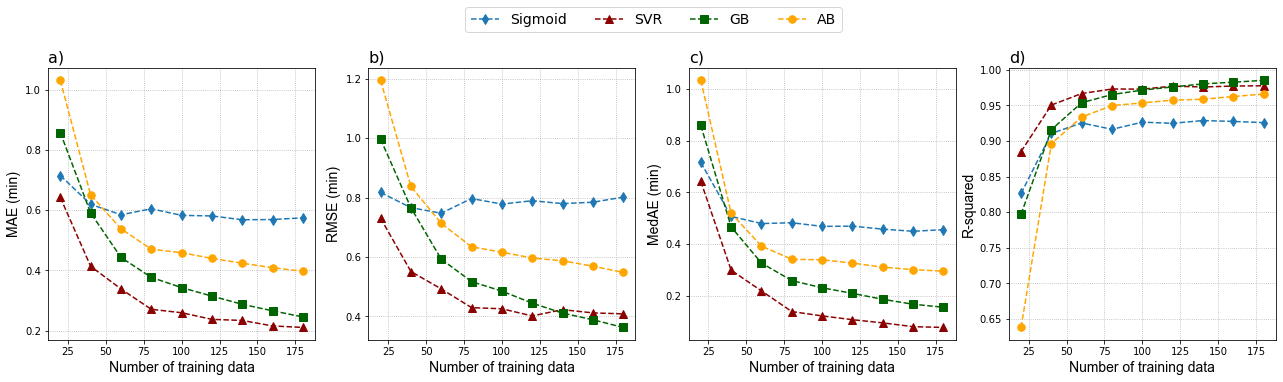

In [6]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(22,5))
fig.patch.set_facecolor('white')
ax1.grid(True, which='major', linestyle=':')
ax2.grid(True, which='major', linestyle=':')
ax3.grid(True, which='major', linestyle=':')
ax4.grid(True, which='major', linestyle=':')

X = range(20, 200, 20)
y1 = sigmoid.MAE
y2 = svr.MAE
y3 = gb.MAE
y4 = ab.MAE
ax1.plot(X, y1, 'd--', markersize=7.5, label='Sigmoid')
# ax.plot(X, y1, '--', color='darkgreen', label='SVR')
ax1.plot(X, y2, '^--', color='darkred', markersize=7.5, label='SVR')
ax1.plot(X, y3, 's--', color='darkgreen', markersize=7.5, label='GB')
ax1.plot(X, y4, 'o--', color='orange', markersize=7.5, label='AB')

# ax1.legend(bbox_to_anchor=(0.9, 0.95))

# fig.suptitle("Model Performance vs Training Size", y=0.96, fontsize=14, fontweight='bold')
ax1.set_xlabel("Number of training data", fontproperties=font1)
ax1.set_ylabel("MAE (min)", fontproperties=font1)



X = range(20, 200, 20)
y1 = sigmoid.RMSE
y2 = svr.RMSE
y3 = gb.RMSE
y4 = ab.RMSE
ax2.plot(X, y1, 'd--', markersize=7.5, label='Sigmoid')
# ax.plot(X, y1, '--', color='darkgreen', label='SVR')
ax2.plot(X, y2, '^--', color='darkred', markersize=7.5, label='SVR')
ax2.plot(X, y3, 's--', color='darkgreen', markersize=7.5, label='GB')
ax2.plot(X, y4, 'o--', color='orange', markersize=7.5, label='AB')

# ax2.legend(bbox_to_anchor=(0.9, 0.95))

# fig.suptitle("Model Performance vs Training Size", y=0.96, fontsize=14, fontweight='bold')
ax2.set_xlabel("Number of training data", fontproperties=font1)
ax2.set_ylabel("RMSE (min)", fontproperties=font1)



y1 = sigmoid.MedAE
y2 = svr.MedAE
y3 = gb.MedAE
y4 = ab.MedAE
ax3.plot(X, y1, 'd--', markersize=7.5, label='Sigmoid')
# ax.plot(X, y1, '--', color='darkgreen', label='SVR')
ax3.plot(X, y2, '^--', color='darkred', markersize=7.5, label='SVR')
ax3.plot(X, y3, 's--', color='darkgreen', markersize=7.5, label='GB')
ax3.plot(X, y4, 'o--', color='orange', markersize=7.5, label='AB')

# ax3.legend(bbox_to_anchor=(0.9, 0.95))

# fig.suptitle("Model Performance vs Training Size", y=0.96, fontsize=14, fontweight='bold')
ax3.set_xlabel("Number of training data", fontproperties=font1)
ax3.set_ylabel("MedAE (min)", fontproperties=font1)


y1 = sigmoid.R2
y2 = svr.R2
y3 = gb.R2
y4 = ab.R2
ax4.plot(X, y1, 'd--', markersize=7.5, label='Sigmoid')
# ax.plot(X, y1, '--', color='darkgreen', label='SVR')
ax4.plot(X, y2, '^--', color='darkred', markersize=7.5, label='SVR')
ax4.plot(X, y3, 's--', color='darkgreen', markersize=7.5, label='GB')
ax4.plot(X, y4, 'o--', color='orange', markersize=7.5, label='AB')

ax4.set_xlabel("Number of training data", fontproperties=font1)
ax4.set_ylabel("R-squared", fontproperties=font1)

ax1.legend(bbox_to_anchor=(3, 1.25),fontsize=14, ncol=4)

# lines, labels = ax4.get_legend_handles_labels()
# fig.legend(lines, labels, loc='upper center', ncol=4, fontsize=14)

# fig.suptitle("", y=0.96, fontproperties=font)

ax1.set_title('a)', loc='left', fontsize=16)
ax2.set_title('b)', loc='left', fontsize=16)
ax3.set_title('c)', loc='left', fontsize=16)
ax4.set_title('d)', loc='left', fontsize=16)


# fig.savefig("/Users/yanyan/Desktop/RT_Model_fig/COM_Learning_curve.png", dpi=300, bbox_inches='tight')


# fig.savefig("COM_Learning_curve.png", dpi=300, bbox_inches='tight')